In [62]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [21]:
ROOT_DIR = os.path.dirname(os.getcwd())
DATA_FOLDER = os.path.join(ROOT_DIR, "data")

In [193]:
files = glob.glob(f'{os.path.join(DATA_FOLDER, "matsi_11022023", "vasen")}/*.MP4')

In [194]:
files

['/home/jakki/git_personal/meow/data/matsi_11022023/vasen/GP040029.MP4',
 '/home/jakki/git_personal/meow/data/matsi_11022023/vasen/GOPR0029.MP4',
 '/home/jakki/git_personal/meow/data/matsi_11022023/vasen/GP030029.MP4',
 '/home/jakki/git_personal/meow/data/matsi_11022023/vasen/GP020029.MP4',
 '/home/jakki/git_personal/meow/data/matsi_11022023/vasen/GP010029.MP4']

In [195]:
def frame_similarity(frame1, frame2):
    
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    frame_height = gray1.shape[0]
    frame_width = gray1.shape[1]
    
    n_pixels = frame_height * frame_width

    diff_frame = cv2.absdiff(frame1, frame2)
    
    thresh_frame = cv2.threshold(src=diff_frame, thresh=50, maxval=255, type=cv2.THRESH_BINARY)[1]
    
    difference = np.sum(thresh_frame)
    difference_per_pixel = difference / n_pixels
    print(difference)
    print(f"Difference in %: {difference_per_pixel}")
    
    return difference_per_pixel

In [196]:
frames = {}

for file_path in files:
    
    capture = cv2.VideoCapture(file_path)
    
    # Read first frame
    capture.set(cv2.CAP_PROP_FRAME_COUNT, 0)
    ret_first, first_frame = capture.read()
    
    # Read last frame
    frame_count = capture.get(cv2.CAP_PROP_FRAME_COUNT)
    capture.set(cv2.CAP_PROP_POS_FRAMES, frame_count-2)
    ret_last, last_frame = capture.read()
    
    if ret_first is False or ret_last is False:
        print(f"Failed to read frame from video {file_path}, first frame: {ret_first}, last frame: {ret_last}")
    
    frames[file_path] = {
        'first_frame': first_frame,
        'last_frame': last_frame
    }
    
    capture.release()

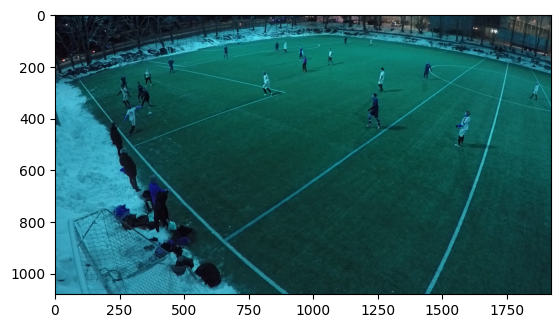

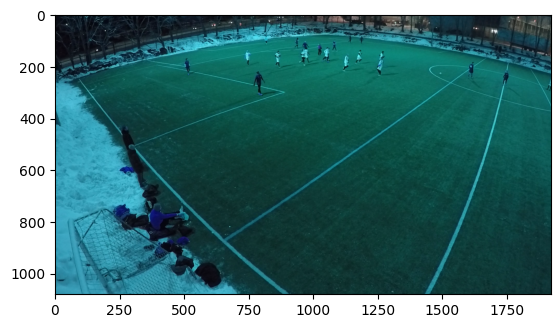

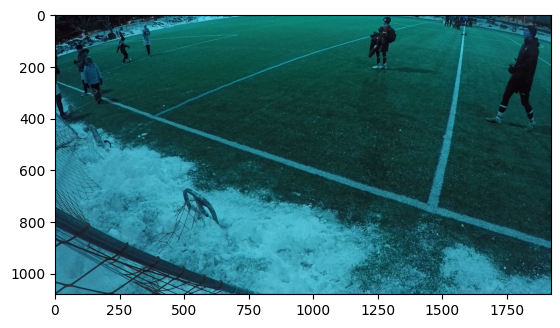

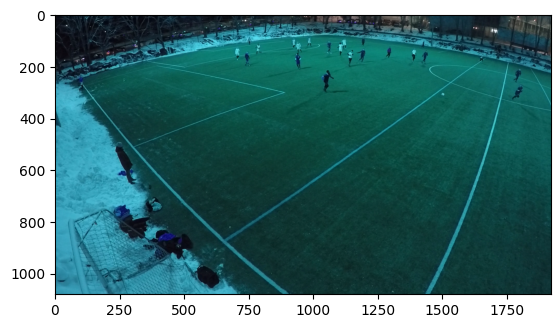

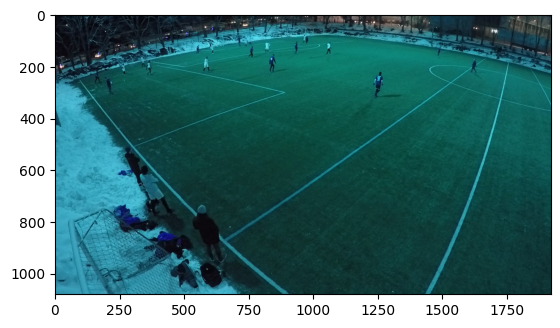

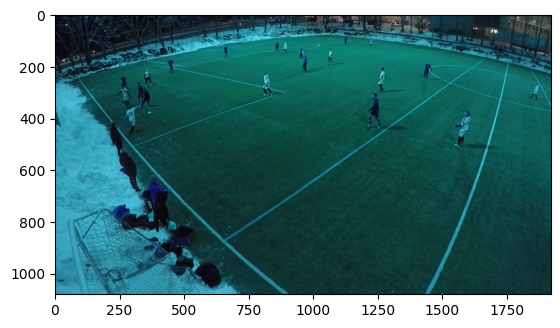

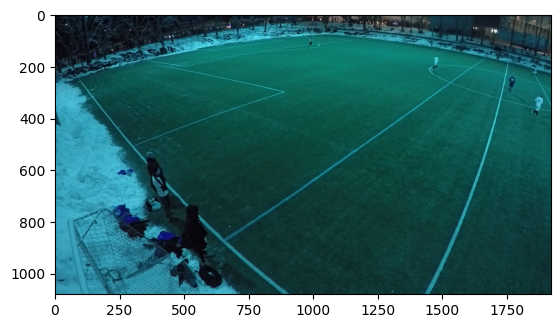

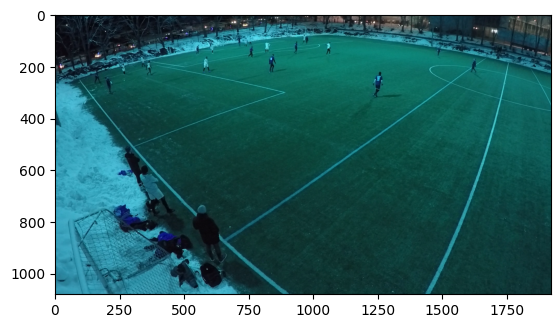

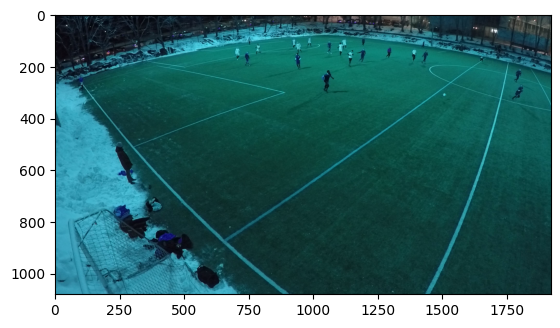

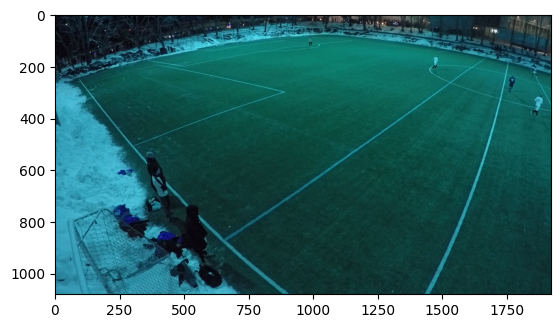

In [197]:
for key, values in frames.items():
    plt.imshow(values['first_frame'])
    plt.show()
    plt.imshow(values['last_frame'])
    plt.show()

In [198]:
# Compare frames
n_files = len(frames)
similarity_matrix = {}

for i, pair1 in enumerate(frames.items()):
    for j, pair2 in enumerate(frames.items()):
        if i < j:
            key1, values1 = pair1
            key2, values2 = pair2
                                    
            first_vs_last = frame_similarity(values1['first_frame'], values2['last_frame'])      
            last_vs_first = frame_similarity(values1['last_frame'], values2['first_frame'])
            
            similarity_matrix[(key1, key2)] = [first_vs_last, last_vs_first]

print(similarity_matrix)

38131680
Difference in %: 18.38912037037037
413191800
Difference in %: 199.26302083333334
589050
Difference in %: 0.2840711805555556
35249160
Difference in %: 16.999016203703704
33045705
Difference in %: 15.936393229166667
25634385
Difference in %: 12.362261284722223
37261620
Difference in %: 17.96953125
41232225
Difference in %: 19.884367766203702
416333400
Difference in %: 200.77806712962962
29744475
Difference in %: 14.344364872685185
413089035
Difference in %: 199.2134620949074
36334440
Difference in %: 17.522395833333334
410988600
Difference in %: 198.20052083333334
376380
Difference in %: 0.18151041666666667
504900
Difference in %: 0.24348958333333334
36408135
Difference in %: 17.557935474537036
33449115
Difference in %: 16.130938946759258
37990155
Difference in %: 18.320869502314814
225930
Difference in %: 0.10895543981481481
28890225
Difference in %: 13.93240017361111
{('/home/jakki/git_personal/meow/data/matsi_11022023/vasen/GP040029.MP4', '/home/jakki/git_personal/meow/data/m

In [199]:
similarity_values = sorted([item for value in similarity_matrix.values() for item in value])
print(similarity_values)

[0.10895543981481481, 0.18151041666666667, 0.24348958333333334, 0.2840711805555556, 12.362261284722223, 13.93240017361111, 14.344364872685185, 15.936393229166667, 16.130938946759258, 16.999016203703704, 17.522395833333334, 17.557935474537036, 17.96953125, 18.320869502314814, 18.38912037037037, 19.884367766203702, 198.20052083333334, 199.2134620949074, 199.26302083333334, 200.77806712962962]


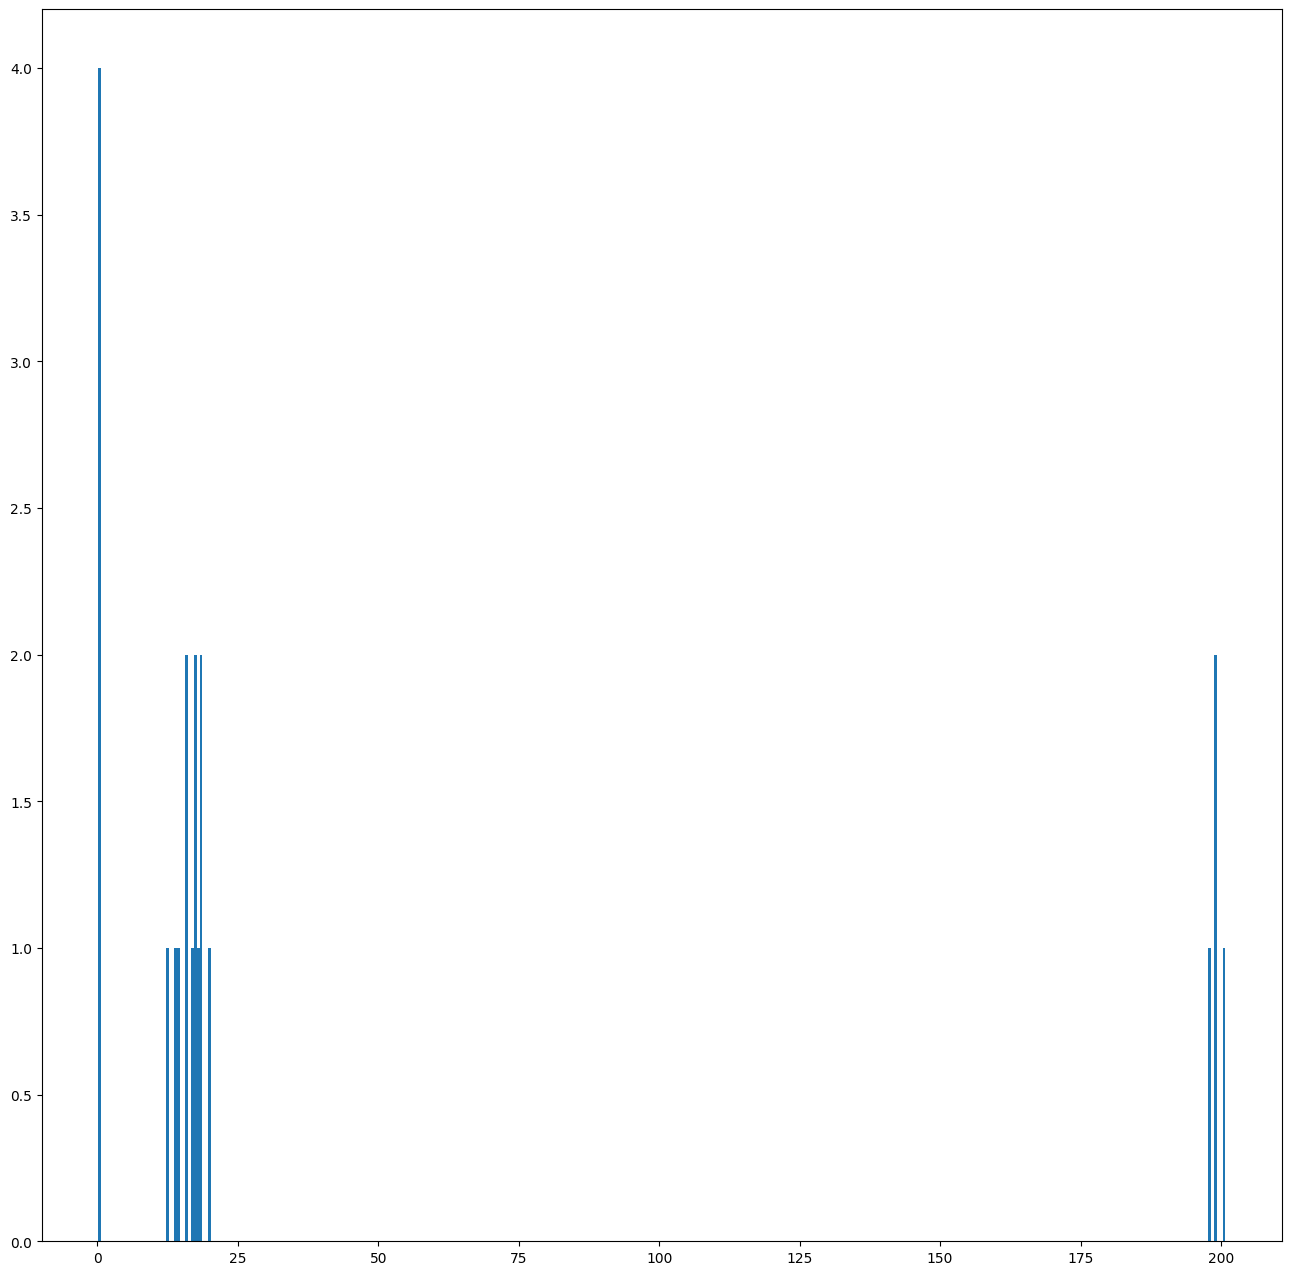

In [200]:
plt.figure(figsize=(16, 16))
plt.hist(similarity_values, bins=400)
plt.show()

In [201]:
print(len([value for value in similarity_values if value < 5]))

4


In [202]:
def add_edge(mapping, node1, node2):
    if node1 in mapping:
        mapping[node1].append(node2)
    else:
        mapping[node1] = [node2]
        
def find_linking(mapping):
    
    valid_linking = check_linking_valid(mapping)
    if valid_linking is False:
        print("Cannot find linked list")
        return None
    
    childs = [value[0] for value in mapping.values()]
    keys = list(mapping.keys())
    
    root_node = list(set(keys) - set(childs))[0]
    order = [root_node]
    
    next_node = None
    last_node = root_node
    for _ in range(len(mapping)):
        next_node = mapping[last_node][0]
        order.append(next_node)
        last_node = next_node
        
    return order
        
def check_linking_valid(mapping):
    """We want to check that
        a) there is only one root node
        b) the chain is not broken eg. each node links to another node
        c) there is only one child node that doesn't exists in keys
        d) each node has exactly one parent except root node and each node has exactly one child
    """
    
    childs = [value[0] for value in mapping.values()]
    keys = list(mapping.keys())
        
    # a)
    
    root_nodes = list(set(keys) - set(childs))
    if len(root_nodes) != 1:
        return False
    
    # b)
    
    visited_nodes = []
    last_node = root_nodes[0]
    next_node = None
    for _ in range(len(mapping)):
        next_nodes = mapping[last_node]
        assert len(next_nodes) == 1
        next_node = next_nodes[0]
        visited_nodes.append(next_node)
        last_node = next_node
        visited_nodes
        
    if len(visited_nodes) != len(mapping):
        return False
    
    # c)
    
    leafs = list(set(childs) - set(keys))
    if len(leafs) != 1:
        return False
    
    return True

In [203]:
threshold = 5

video_linking = {}

for key, values in similarity_matrix.items():
    key1 = key[0]
    key2 = key[1]
    value1 = values[0]
    value2 = values[1]
    
    if value1 < threshold:
        add_edge(video_linking, key2, key1)
    if value2 < threshold:
        add_edge(video_linking, key1, key2)

In [204]:
video_linking

{'/home/jakki/git_personal/meow/data/matsi_11022023/vasen/GP030029.MP4': ['/home/jakki/git_personal/meow/data/matsi_11022023/vasen/GP040029.MP4'],
 '/home/jakki/git_personal/meow/data/matsi_11022023/vasen/GOPR0029.MP4': ['/home/jakki/git_personal/meow/data/matsi_11022023/vasen/GP010029.MP4'],
 '/home/jakki/git_personal/meow/data/matsi_11022023/vasen/GP020029.MP4': ['/home/jakki/git_personal/meow/data/matsi_11022023/vasen/GP030029.MP4'],
 '/home/jakki/git_personal/meow/data/matsi_11022023/vasen/GP010029.MP4': ['/home/jakki/git_personal/meow/data/matsi_11022023/vasen/GP020029.MP4']}

In [205]:
find_linking(video_linking)

['/home/jakki/git_personal/meow/data/matsi_11022023/vasen/GOPR0029.MP4',
 '/home/jakki/git_personal/meow/data/matsi_11022023/vasen/GP010029.MP4',
 '/home/jakki/git_personal/meow/data/matsi_11022023/vasen/GP020029.MP4',
 '/home/jakki/git_personal/meow/data/matsi_11022023/vasen/GP030029.MP4',
 '/home/jakki/git_personal/meow/data/matsi_11022023/vasen/GP040029.MP4']